In [1]:
!pip install SentencePiece
!pip install rouge


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import pandas as pd
import torch
import numpy as np
import random
import os
import torch.optim as optim 
from tqdm import tqdm 
import matplotlib.pyplot as plt 

In [3]:
def set_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(0)

## 讀檔

In [4]:
x_train, y_train, x_valid, y_valid= [], [], [], []
for types in os.listdir('SummaryData'):
    classes_path = f'SummaryData/{types}'
    for classes in os.listdir(classes_path):
        file_path = f'{classes_path}/{classes}'
        df = pd.read_csv(file_path).values
        input_text = ["summarize: " + i for i in df[:,1]]
        summary = df[:,0]
        if types == 'Train':
            x_train.extend(input_text)
            y_train.extend(summary)
        
        else:
            x_valid.extend(input_text)
            y_valid.extend(summary)
tokenizer = T5Tokenizer.from_pretrained("t5-large")
PAD_IDX = tokenizer.pad_token_id

c:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\transformers\models\t5\tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


## 創建資料集

In [5]:
class News(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
trainset = News(x_train, y_train)
validset = News(x_valid, y_valid)


In [6]:
def collate_fn(batch):   
    (x, y) = zip(*batch)
    tokens = tokenizer(x, truncation=True, max_length=128, padding="longest", return_tensors='pt')
    input_ids = tokens.input_ids
    attention_mask = tokens.attention_mask
    labels = tokenizer(y, truncation=True, max_length=128, padding="longest", return_tensors='pt').input_ids
    labels[labels == PAD_IDX] = -100
    return input_ids, attention_mask, labels
      

train_loader = DataLoader(trainset, batch_size = 8, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)
valid_loader = DataLoader(validset, batch_size = 8, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = T5ForConditionalGeneration.from_pretrained("t5-large").to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def train(epoch):
    train_loss = 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() # 將模型切換成訓練模式
    for input_datas in train_pbar: 
        features, maskes, labels = [i.to(device) for i in input_datas] # 將資料放入到GPU中
        optimizer.zero_grad()  # 梯度清零
        outputs = model(input_ids =features , attention_mask = maskes, labels = labels) # 模型計算答案(前向傳播)

        loss = outputs.loss

        loss.backward() # 返向傳播
        optimizer.step() # 更新模型權重
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # 顯示訓練次數
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # 顯示當下模型損失

        train_loss += loss.item()  # 模型總損失
    return train_loss/len(train_loader)

def valid(epoch):
    valid_loss = 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            features, maskes, labels = [i.to(device) for i in input_datas] # 將資料放入到GPU中
        
            outputs = model(input_ids = features , attention_mask = maskes, labels = labels)

            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            valid_loss += loss.item()

    return valid_loss/len(valid_loader)

        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

Valid Epoch 0: 100%|██████████| 14222/14222 [17:37<00:00, 13.45it/s, loss=1.766]


Saving Model With Loss 2.25595
Train Loss: 2.65385 Valid Loss: 2.25595| Best Loss: 2.25595



Valid Epoch 1: 100%|██████████| 14222/14222 [17:36<00:00, 13.47it/s, loss=2.418]


Saving Model With Loss 2.03159
Train Loss: 1.67018 Valid Loss: 2.03159| Best Loss: 2.03159



Valid Epoch 2: 100%|██████████| 14222/14222 [17:35<00:00, 13.47it/s, loss=2.272]


Train Loss: 1.36647 Valid Loss: 2.04746| Best Loss: 2.03159



Valid Epoch 3: 100%|██████████| 14222/14222 [17:07<00:00, 13.84it/s, loss=1.613]


Train Loss: 1.11982 Valid Loss: 2.04645| Best Loss: 2.03159



Valid Epoch 4: 100%|██████████| 14222/14222 [17:07<00:00, 13.84it/s, loss=1.911]


Saving Model With Loss 2.02005
Train Loss: 0.92086 Valid Loss: 2.02005| Best Loss: 2.02005



Valid Epoch 5: 100%|██████████| 14222/14222 [17:33<00:00, 13.50it/s, loss=2.463]


Train Loss: 0.77247 Valid Loss: 2.13717| Best Loss: 2.02005



Valid Epoch 6: 100%|██████████| 14222/14222 [17:04<00:00, 13.89it/s, loss=2.247]


Train Loss: 0.65550 Valid Loss: 2.19584| Best Loss: 2.02005



Valid Epoch 7: 100%|██████████| 14222/14222 [17:03<00:00, 13.89it/s, loss=1.968]


------------------------------------
|Model can't improve, stop training|
------------------------------------


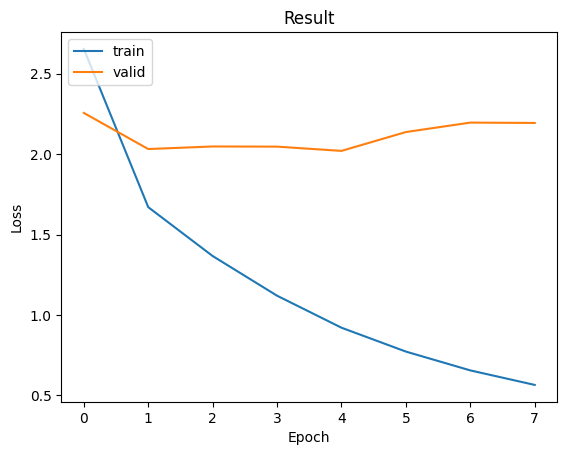

In [9]:
epochs = 10                              # 訓練次數
early_stopping = 3                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_loss = float('inf')                             # 最佳的準確率
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss = train(epoch)
    valid_loss = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Loss {valid_loss:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f} Valid Loss: {valid_loss:.5f}', end='| ')
    print(f'Best Loss: {best_loss:.5f}', end='\n\n')

if show_loss:
    show_training_loss(loss_record)
        

In [10]:
model = T5ForConditionalGeneration.from_pretrained("t5-large").to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [11]:
data_idx = 5000
input_ids = tokenizer(x_valid[data_idx], return_tensors='pt').input_ids.to(device)
generated_ids = model.generate(input_ids, num_beams=2, max_length=30, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
preds = [tokenizer.decode(i, skip_special_tokens=True, clean_up_tokenization_spaces=True) for i in generated_ids][0]
print('原始文章:\n', x_valid[data_idx])
print('原始摘要:\n', y_valid[data_idx])
print('生成摘要:\n', preds)


原始文章:
 summarize: jio wednesday announced launch 25000kilometre asiaafricaeurope aae1 submarine cable system . jio claimed longest technologybased 100 gbps gigabits per second submarine cable system world stretching france hong kong 21 cable landings across asia europe . project combined work leading service providers various countries .
原始摘要:
 jio launches worlds longest 100gbps underwater cable system
生成摘要:
 jio wednesday announced launch 25000kilometre asiaafricaeurope aae1 submarine cable system


In [23]:
from rouge import Rouge
rouge = Rouge()
score = rouge.get_scores(y_valid[data_idx],preds)[0]
for i in score[0]:
    print(score[i])

TypeError: list indices must be integers or slices, not str